# BTC price prediction

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
FILES_PATH = '/content/drive/MyDrive/colab_files/'

In [3]:
! cd $FILES_PATH; ls

augmented_big.zip  augmentedv3.zip  btc_35040.csv  data.yaml  oldruns.zip
augmentedv2.zip    augmented.zip    dataset	   data.zip   runs.zip


## EDA

In [4]:
import numpy as np
import pandas as pd

from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
df = pd.read_csv(FILES_PATH + 'btc_35040.csv', index_col=0)
df

,time,open,close,high,low,volume,turnover
0,1694692800,26446.2,26439.2,26472.6,26428.5,8.281884,2.190531e+05
1,1694691900,26369.9,26446.1,26489.0,26368.3,86.392787,2.283123e+06
2,1694691000,26374.3,26369.9,26400.0,26360.5,30.212272,7.969732e+05
3,1694690100,26351.1,26374.4,26375.0,26342.4,25.699080,6.773575e+05
4,1694689200,26332.5,26351.0,26351.1,26329.0,16.011302,4.217789e+05
...,...,...,...,...,...,...,...
35035,1663161300,20376.6,20335.3,20381.2,20321.4,58.887554,1.198164e+06
35036,1663160400,20311.2,20376.6,20385.9,20270.9,112.401328,2.286843e+06
35037,1663159500,20313.7,20312.6,20332.0,20244.0,88.319159,1.792011e+06
35038,1663158600,20212.3,20313.7,20343.0,20130.2,193.487012,3.920462e+06


In [6]:
df.columns

Index(['time', 'open', 'close', 'high', 'low', 'volume', 'turnover'], dtype='object')

In [7]:
plt.rcParams['figure.figsize'] = (20, 5)

decrease_color = 'red'
increase_color = 'green'

width = .3
width2 = .03

In [8]:
def candles_plot(dataframe, count=40, start_idx=None):
    if not start_idx:
        start_idx = len(dataframe) - count

    st = start_idx
    end = min(len(dataframe), start_idx + count)
    stock_prices = dataframe[st:end]

    up = stock_prices[stock_prices.close >= stock_prices.open]
    down = stock_prices[stock_prices.close < stock_prices.open]

    plt.bar(up.index, up.close-up.open, width, bottom=up.open, color=decrease_color)
    plt.bar(up.index, up.high-up.low, width2, bottom=up.low, color=decrease_color)

    plt.bar(down.index, down.close-down.open, width, bottom=down.open, color=increase_color)
    plt.bar(down.index, down.high-down.low, width2, bottom=down.low, color=increase_color)

    plt.title(f'Last {count} candles of BTC price at Kucoin')

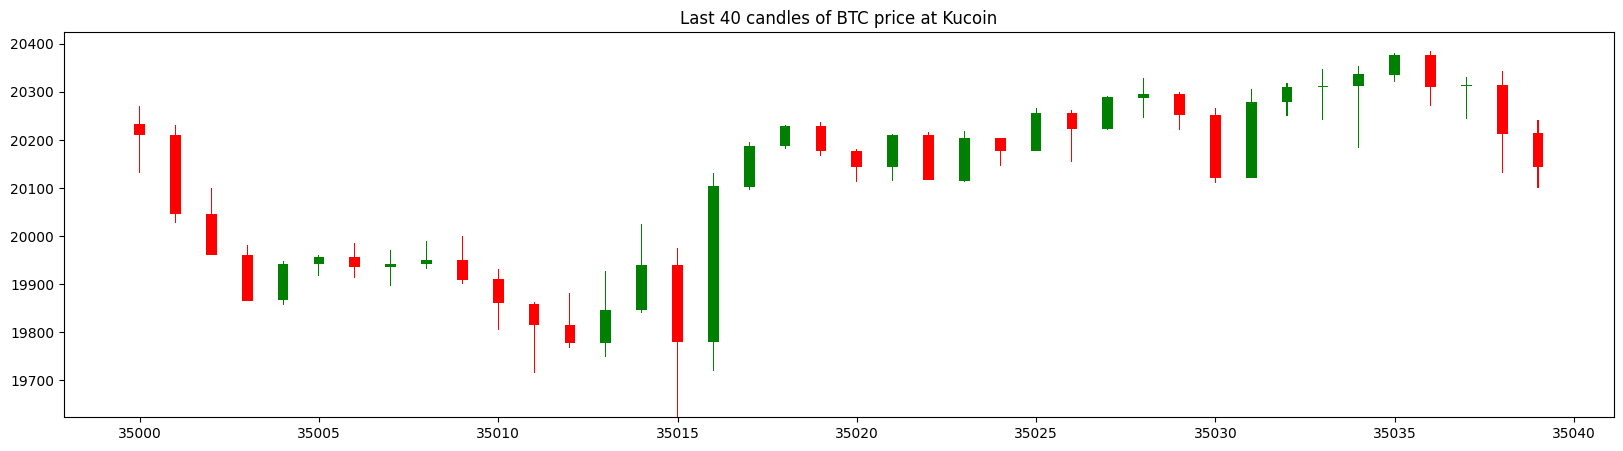

In [9]:
candles_plot(df, count=40)

## Data preprocessing

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
cols = ['open', 'close', 'high', 'low', 'volume', 'turnover']

unscaled_train_df, val_df = train_test_split(df[cols], test_size=0.2, shuffle=False)

len(unscaled_train_df), len(val_df)

(28032, 7008)

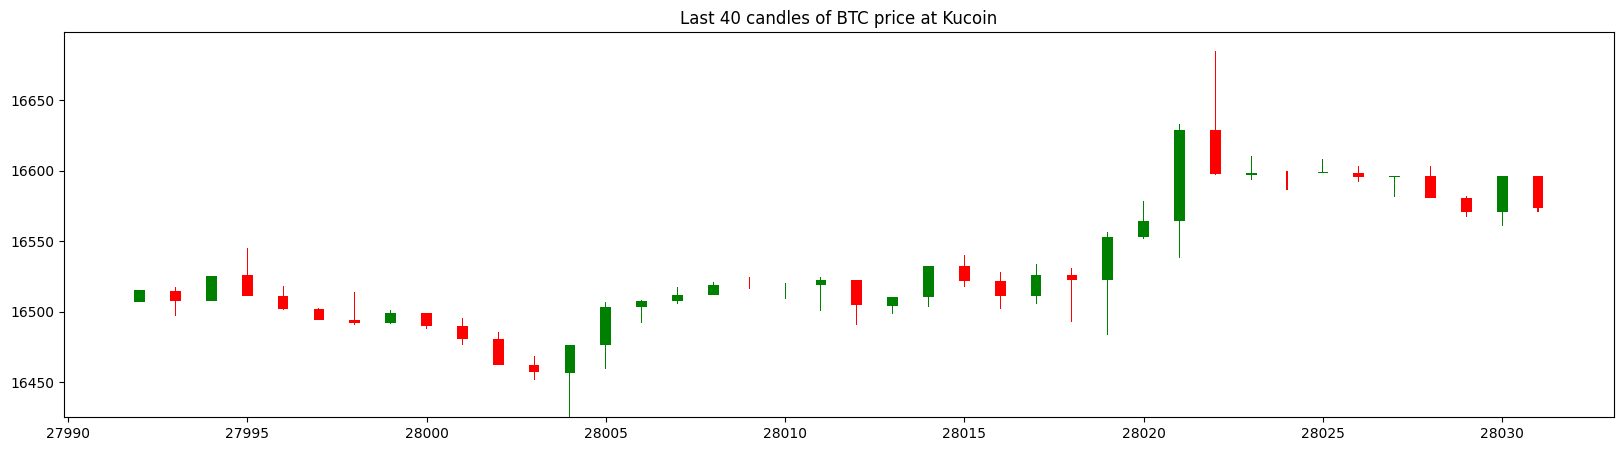

In [12]:
candles_plot(unscaled_train_df, count=40)

In [13]:
from sklearn.preprocessing import StandardScaler

In [14]:
scaler = StandardScaler()
train_df = pd.DataFrame(scaler.fit_transform(unscaled_train_df), columns=cols)

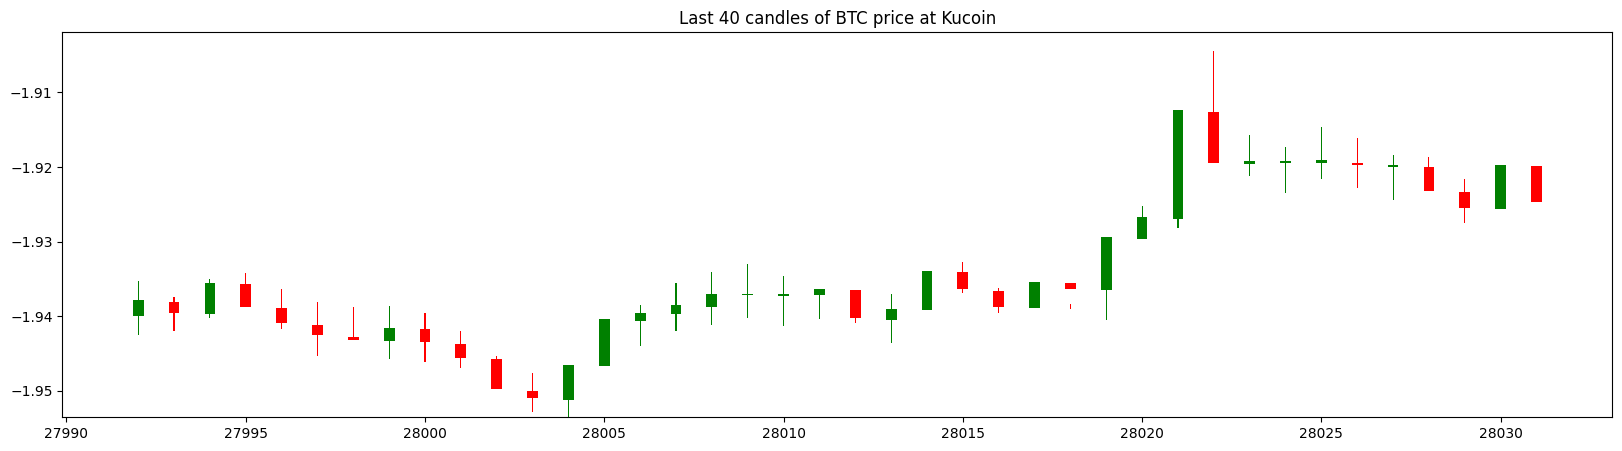

In [15]:
candles_plot(train_df, count=40)

## Datasets & dataloaders

In [16]:
import torch
from torch.utils.data import Dataset, DataLoader

In [17]:
def create_dataset(dataset, lookback):
    X, y = [], []

    for i in range(len(dataset)-lookback):
        if isinstance(dataset, pd.DataFrame):
            feature = dataset[i:i+lookback].values.astype(np.float32)
            target = dataset[i+1:i+lookback+1].values.astype(np.float32)
        else:
            feature = dataset[i:i+lookback].astype(np.float32)
            target = dataset[i+1:i+lookback+1].astype(np.float32)
        X.append(feature)
        y.append(target)

    return torch.tensor(np.array(X)), torch.tensor(np.array(y))

In [18]:
lookback = 20
X_train, y_train = create_dataset(train_df, lookback=lookback)
X_val, y_val = create_dataset(val_df, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

torch.Size([28012, 20, 6]) torch.Size([28012, 20, 6])
torch.Size([6988, 20, 6]) torch.Size([6988, 20, 6])


In [19]:
class BtcDataset(Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.length = X.shape[0]

    def __getitem__(self, idx):
        X = self.X[idx]
        Y = self.y[idx]
        return X, Y

    def __len__(self):
        return self.length

In [20]:
train_dataset = BtcDataset(X_train, y_train)
val_dataset = BtcDataset(X_val, y_val)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=32)
val_dataloader = DataLoader(val_dataset, shuffle=True, batch_size=32)

In [21]:
X, y = next(iter(train_dataloader))

X.shape, y.shape

(torch.Size([32, 20, 6]), torch.Size([32, 20, 6]))

## Model construction

In [22]:
import torch
import torch.nn as nn

In [23]:
class BtcNet(nn.Module):

    def __init__(self, hidden_size=100):
        super().__init__()

        self.hidden_size = hidden_size

        self.rnn = nn.LSTM(input_size=6, hidden_size=hidden_size, batch_first=True)

        self.linear = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size // 2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size // 2, out_features=6),
        )

    def forward(self, x, hidden=None):
        # x: [BATCH_SIZE x CANDLES_COUNT x 6]

        out, _ = self.rnn(x, hidden)
        # out: torch.Size([BATCH_SIZE, CANDLES_COUNT, 100])

        out = self.linear(out)
        # out: torch.Size([BATCH_SIZE, CANDLES_COUNT, 6])

        return out

## Training

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [25]:
mu, std = scaler.mean_, scaler.var_


def scale(batch, mu=mu, std=std):
    batch = (batch - mu) / std
    return batch.float()


mu, std

(array([2.51558479e+04, 2.51561827e+04, 2.51873644e+04, 2.51231384e+04,
        4.81441936e+01, 1.18469958e+06]),
 array([1.98812066e+07, 1.98785646e+07, 1.99311663e+07, 1.98238614e+07,
        4.73339826e+03, 3.00013048e+12]))

In [26]:
from IPython.display import clear_output


losses = {
    'train': [],
    'val': []
}


def train(model, optimizer, criterion, epoches, tr_loader, val_loader):
    for epoch in range(epoches):
        # training
        model.train()
        train_loss = 0

        for X_batch, Y_batch in tr_loader:
            X_batch_cuda = X_batch.to(device)
            out = model.forward(X_batch_cuda)

            optimizer.zero_grad()
            loss = criterion(out, Y_batch.to(device))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(tr_loader)
        losses['train'].append(train_loss**0.5)

        # validation
        model.eval()
        val_loss = 0

        for X_val, Y_val in val_loader:
            X_val = scale(X_val)
            Y_val = scale(Y_val)

            X_val_cuda = X_val.to(device)

            with torch.no_grad():
                out = model.forward(X_val_cuda)

            loss = criterion(out, Y_val.to(device))

            val_loss += loss.item()

        val_loss /= len(val_loader)
        losses['val'].append(val_loss**0.5)

        # show result & visualization
        print(f'Epoch: {epoch+1}/{epoches}; Train loss: {train_loss}; Val loss: {val_loss}')

In [29]:
model = BtcNet().to(device)

epoches = 10
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

In [30]:
train(model, optimizer, criterion, epoches, train_dataloader, val_dataloader)

Epoch: 1/10; Train loss: 0.39141227879888935; Val loss: 0.002083576215243979
Epoch: 2/10; Train loss: 0.21182400792769102; Val loss: 0.0022213405166161522
Epoch: 3/10; Train loss: 0.20195935871111884; Val loss: 0.0031256851608350397
Epoch: 4/10; Train loss: 0.19768358637327882; Val loss: 0.002921666218537718
Epoch: 5/10; Train loss: 0.1943976220815149; Val loss: 0.0051749337732485716
Epoch: 6/10; Train loss: 0.19215018674305992; Val loss: 0.0076417623717150735
Epoch: 7/10; Train loss: 0.19039887471388192; Val loss: 0.009283033361207676
Epoch: 8/10; Train loss: 0.18911738345850276; Val loss: 0.0077044803300472696
Epoch: 9/10; Train loss: 0.1880664400007899; Val loss: 0.009199066950884311
Epoch: 10/10; Train loss: 0.18705272549958943; Val loss: 0.010814132015794923


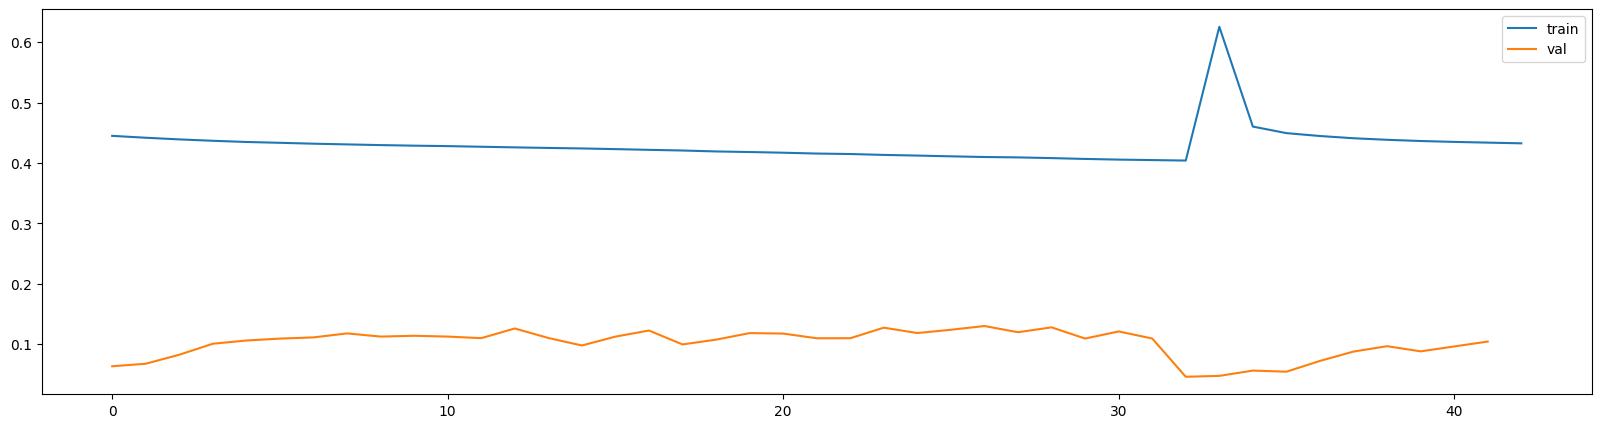

In [31]:
# visualization

skip_losses = 3
plt.plot(losses['train'][skip_losses:], label='train')
plt.plot(losses['val'][skip_losses:], label='val')
plt.legend()

## Testing

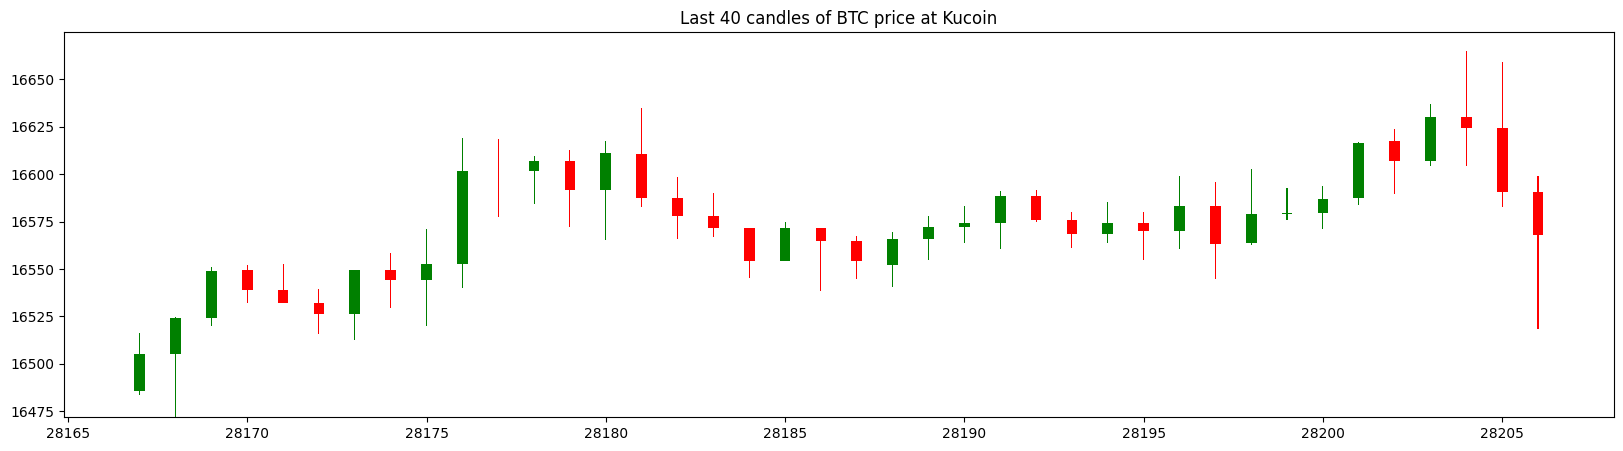

In [42]:
start_idx, count = 135, 40
full_x = val_df[start_idx:start_idx+count]

candles_plot(full_x)

In [43]:
def predict(x, count=4, receptive_field=20):
    model.eval()

    with torch.no_grad():
        x = torch.tensor(x).to(device)

        for i in range(count):
            candles = model(x[:, -receptive_field:])
            last_candle = candles[-1, :].unsqueeze(0)
            x = torch.cat((x, last_candle), dim=0)

    return x.cpu().detach().numpy()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


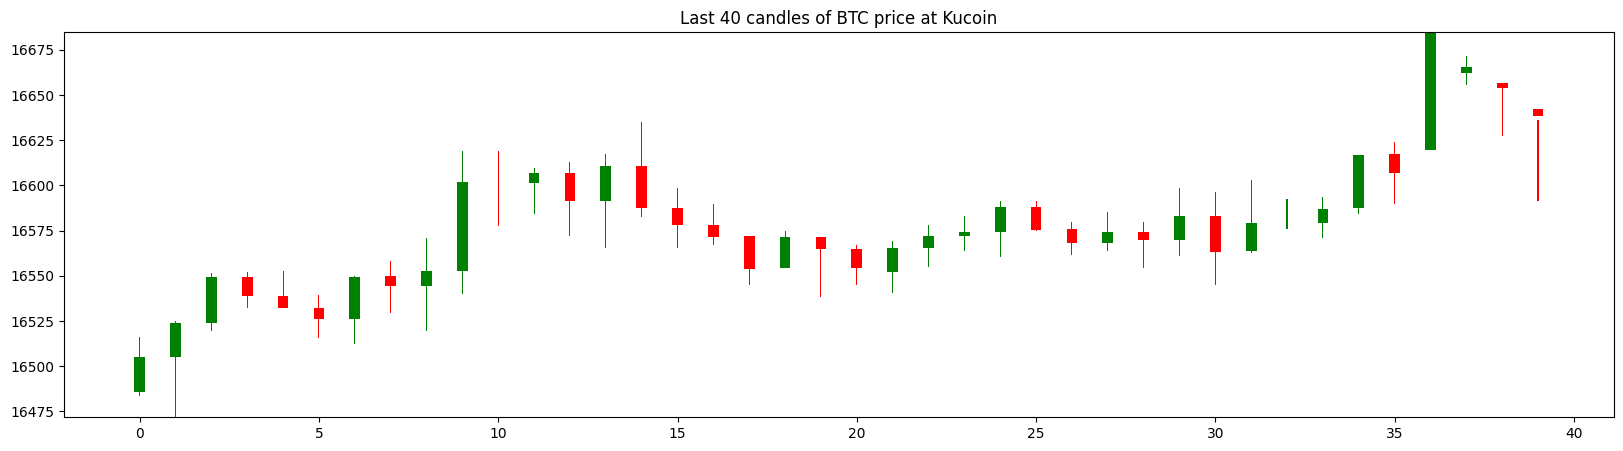

In [44]:
x = full_x[:count-4].values.astype(np.float32)
x = scaler.transform(x)

candles = predict(x)
candles = scaler.inverse_transform(candles)

candles_pd = pd.DataFrame(candles, columns=cols)
candles_plot(candles_pd)

## Saving weights

In [45]:
PATH = '/content/drive/MyDrive/BTC_RNN_weights.saved'

torch.save(model.state_dict(), PATH)